In [808]:
import numpy as np
import scipy as sci
import scipy.io
from sklearn import svm
from skimage import feature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import csv
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import Imputer
import sklearn.preprocessing as pp
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import math
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [809]:
def create_csv(pred, name):
    np.savetxt(name, np.dstack((np.arange(1, len(pred)+1), pred))[0],"%d,%d",header="Id,Category")

def benchmark(pred_labels, true_labels):
    errors = pred_labels != true_labels
    err_rate = sum(errors) / float(len(true_labels))
    indices = errors.nonzero()
    return err_rate, indices


In [810]:
# initialize data
train = scipy.io.loadmat("dataset/train.mat")
test = scipy.io.loadmat("dataset/test.mat")
test = test['test_images']

images = train['train_images']
labels = train['train_labels']

test_data = np.zeros((10000, 28*28))
for i in range(10000):
    test_data[i] = test[i].reshape((28*28,))
    
images_reshaped = np.zeros((60000, 28*28))
for i in range(60000):
    curr = []
    for j in range(28):
        for k in range(28):
            curr.append(images[j][k][i])
    images_reshaped[i] = curr

In [811]:
images_reshaped = pp.normalize(images_reshaped)
test_data = pp.normalize(test_data)

In [812]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [814]:
def transform(n):
    ret = np.zeros(10)
    ret[n] = 1
    return ret

In [1049]:
class Neural_Network(object):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.inputLayerSize = images.shape[1]
        self.outputLayerSize = 10
        self.hiddenLayerSize = 200
        
        self.V = 0.01 * np.random.randn(self.hiddenLayerSize, \
                                        self.inputLayerSize + 1)
        self.W = 0.01 * np.random.randn(self.outputLayerSize, \
                                        self.hiddenLayerSize + 1)
        
    def forward(self, images):
        ones = np.ones((len(images), 1))
        bias_images = np.hstack((images, ones))
        self.a = self.V.dot(bias_images.T)
        self.b = np.tanh(self.a)
        bias_b = np.vstack((self.b, ones.T))
        self.c = self.W.dot(bias_b)
        self.d = sigmoid(self.c)
        return self.d.T

    def transform_to_labels(self, predictions):
        results = np.zeros(len(predictions))
        for i in range(len(predictions)):
            results[i] = np.argmax(predictions[i])
        return results.reshape(len(results), 1)
    
    def transform_to_tens(self, predictions):
        results = np.zeros((len(predictions), 10))
        for i in range(len(predictions)):
            results[i][predictions[i]] = 1
        return results
    
    # only one hidden layer
    def predict(self, images):
        result = self.forward(images)
        return self.transform_to_labels(result)
    
    def MSE(self):
        pred = self.forward(self.images)
        actual = self.transform_to_tens(self.labels)
        diff_sq = (pred-actual)**2
        result = 0.5 * np.sum(diff_sq)
        return result
    
    def CEE(self):
        pred = self.forward(self.images)
        actual = self.transform_to_tens(self.labels)
        diff = actual*np.log(pred)+(1-actual)*(np.log(1-pred))
        result = -1*np.sum(diff)
        return result
    
    def train(self, learning_rate = 0.2, cost = "MSE", hidden_size = 200, num_labels = 10, num_epochs = 10, calc_error = False):
        curr_epochs = 0
        counter = 0
        x_vals = []
        errors = []
        accuracy = []
        while(curr_epochs < num_epochs):
            if curr_epochs%10==0:
                counter = 0
            for i in range(len(self.images)):
                num = np.random.randint(len(self.images))

                sample = np.hstack((self.images[num], 1))
                # we are doing stoch. grad. descent, so if we have sample i, then we must update V_i and W_i with the gradients dL/dV_i and dL/dW_i
                # perform forward pass, where we calculate and store the gradients for hidden layer, and output layer
                a = sample.dot(self.V.T) # a 1x200 vector for this sample's inputs to the hidden layer
                b = np.hstack((np.tanh(a), 1))
                c = self.W.dot(b)
                d = sigmoid(c) # should be a 1x10 vector for this sample's output layer
    
                # for V
                
                dVi_forward = sample
                da_forward = np.hstack((1-np.tanh(a)**2, 1))
                db_forward = self.W.T

                # for both
                dd = - (transform(self.labels[num]) - d)
                # for cross entropy, divide by d*(1-d)
                if cost == "CEE":
                    dd = dd/(d*(1-d))
                
                # for W
                dWi_forward = b
                dc_forward = sigmoid(c)*(1-sigmoid(c))
                dc = dd * dc_forward 
                
                # perform backward pass
                # for V
                db = db_forward.dot(dc)
                da = db * da_forward.T
                da = da.reshape(201, 1)
                dVi_forward = dVi_forward.reshape(785, 1)
                dVi = da.dot(dVi_forward.T)

                # for W
                dc = dc.reshape(10, 1)
                dWi_forward = dWi_forward.reshape(201, 1)
                dWi = dc.dot(dWi_forward.T)
                
                # update weights
                self.V = self.V - learning_rate * dVi[:200] / (counter + 1)
                self.W = self.W - learning_rate * dWi[:200] / (counter + 1)
                if calc_error:
                    if i%2000==0:
                        results = NN.predict(self.images)
                        error_rate, indices = benchmark(results, self.labels)
                        accuracy.append(1-error_rate)
                        x_vals.append(curr_epochs*len(self.images) + i)
                        if cost == "CEE":
                            errors.append(self.CEE())
                        else:
                            errors.append(self.MSE())
            curr_epochs+=1
            counter+=1
        return self.V, self.W, x_vals, errors, accuracy

For the learning rate, I tried various learning rates to find which one gave me better results, and a learning rate of 0.2 was the best one I got. I stopped training after I trained over a certain number of epochs, specified in the train() method. I initialized the weights randomly from a normal distribution with a mean of 0 and a standard deviation of 0.01.

## Mean Squared Error

In [1062]:
train, val_set, train_labels, val_labels = train_test_split(images_reshaped, labels, test_size = int(len(labels)/6), random_state = 0)
begin = time.time()
NN = Neural_Network(train, train_labels)
NN.forward(train)
V, W, x_vals, errors, accuracy = NN.train(num_epochs = 20, cost = "MSE", calc_error = True)
end = time.time()
elapsed = end - begin
print("It took", elapsed, "seconds to train")

It took 1527.983106136322 seconds to train


In [1063]:
train_results = NN.predict(train)
error_rate, indices = benchmark(train_results, train_labels)
print("The training accuracy is", 1 - error_rate)

val_results = NN.predict(val_set)
error_rate, indices = benchmark(val_results, val_labels)
print("The validation accuracy is", 1 - error_rate)

The training accuracy is 0.9511
The validation accuracy is 0.9391


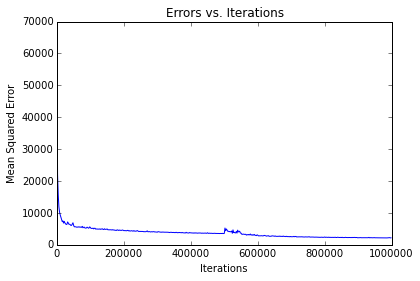

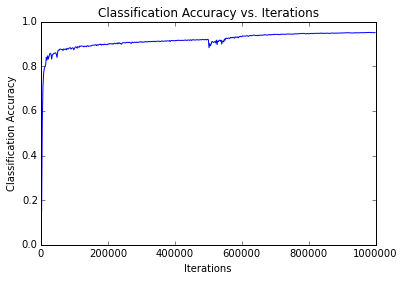

In [1064]:
plt.plot(x_vals, errors)
plt.title('Errors vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.show()

plt.plot(x_vals, accuracy)
plt.title('Classification Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Classification Accuracy')
plt.show()

## Cross Entropy Error

In [1065]:
train, val_set, train_labels, val_labels = train_test_split(images_reshaped, labels, test_size = int(len(labels)/6), random_state = 0)
begin = time.time()
NN = Neural_Network(train, train_labels)
NN.forward(train)
V, W, x_vals, errors, accuracy = NN.train(num_epochs = 20, cost = "CEE", calc_error = True)
end = time.time()
elapsed = end - begin
print("It took", elapsed, "seconds to train")

It took 1551.7008900642395 seconds to train


In [1066]:
train_results = NN.predict(train)
error_rate, indices = benchmark(train_results, train_labels)
print("The training accuracy is", 1 - error_rate)

val_results = NN.predict(val_set)
error_rate, indices = benchmark(val_results, val_labels)
print("The validation accuracy is", 1 - error_rate)

The training accuracy is 0.97444
The validation accuracy is 0.9548


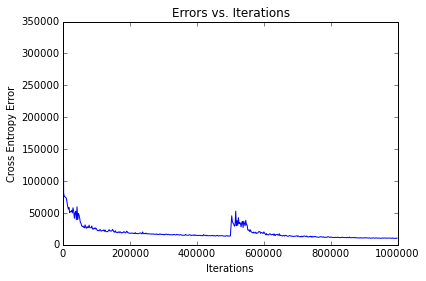

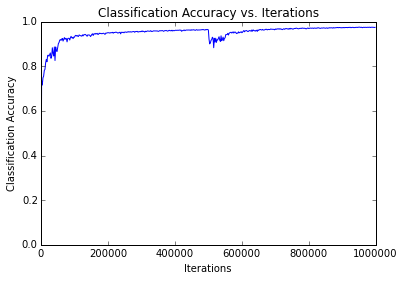

In [1067]:
plt.plot(x_vals, errors)
plt.title('Errors vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Error')
plt.show()

plt.plot(x_vals, accuracy)
plt.title('Classification Accuracy vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('Classification Accuracy')
plt.show()

The mean squared error and cross entropy error differ in that the cross entropy error is the mean squared error divided by $z_k(x)\cdot(1-z_k(x))$. The mean squared error is good for regression, while the cross entropy error is good for classification because the cross entropy error puts an exponential penalty when the classification is further away from its correct label . For my neural network, using the cross entropy error results in better performance.

## Creating the Kaggle submission

In [1068]:
train, val_set, train_labels, val_labels = train_test_split(images_reshaped, labels, test_size = int(len(labels)/6), random_state = 0)
begin = time.time()
NN = Neural_Network(train, train_labels)
NN.forward(train)
V, W, x_vals, errors, accuracy = NN.train(num_epochs = 60, cost = "CEE")
end = time.time()
elapsed = end - begin
print("It took", elapsed, "seconds to train")

It took 2774.18972492218 seconds to train


In [1069]:
val_results = NN.predict(val_set)
error_rate, indices = benchmark(val_results, val_labels)
print("The validation accuracy is", 1 - error_rate)

The validation accuracy is 0.9599


In [1070]:
results = NN.predict(test_data)
results = results.reshape((len(results),))
create_csv(results, "digits.csv")

My best Kaggle score was 0.9728